# Heart disease risk prediction
### Use the logistic regressipon to ake a prediction of heart disease.

#### dataset: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Data contains; 

- age - age in years 
- sex - (1 = male; 0 = female) 
- cp - chest pain type 
- trestbps - resting blood pressure (in mm Hg on admission to the hospital) 
- chol - serum cholestoral in mg/dl 
- fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
- restecg - resting electrocardiographic results 
- thalach - maximum heart rate achieved 
- exang - exercise induced angina (1 = yes; 0 = no) 
- oldpeak - ST depression induced by exercise relative to rest 
- slope - the slope of the peak exercise ST segment 
- ca - number of major vessels (0-3) colored by flourosopy 
- thal - 3 = normal; 6 = fixed defect; 7 = reversable defect 
- target - have disease or not (1=yes, 0=no)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pickle

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

/Users/pengxu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
df = pd.read_csv("heart.csv")

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


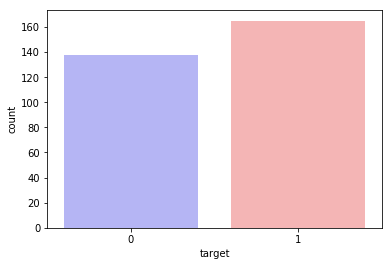

In [4]:
df.target.value_counts()
sns.countplot(x="target", data=df, palette="bwr")
plt.show()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


In [6]:
y = df.target
X = df.drop("target", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=1234)
print( len(X_train), len(X_test), len(y_train), len(y_test) )

242 61 242 61


In [7]:
pipelines = {
    'l1' : make_pipeline(LogisticRegression(penalty='l1' , random_state=1234)),
    'l2' : make_pipeline(LogisticRegression(penalty='l2' , random_state=1234)),
    'rf' : make_pipeline(RandomForestClassifier(random_state=1234))
}

# Logistic Regression hyperparameters
l1_hyperparameters = {
    'logisticregression__C' : np.linspace(1e-3, 1e3, 10),
}

l2_hyperparameters = {
    'logisticregression__C' : np.linspace(1e-3, 1e3, 10),
}
# Random Forest hyperparameters
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33]
}

# Create hyperparameters dictionary
hyperparameters = {
    'l1' : l1_hyperparameters,
    'l2' : l2_hyperparameters,
    'rf' : rf_hyperparameters
}

In [8]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

l1 has been fitted.
l2 has been fitted.
rf has been fitted.


In [9]:
# Display best_score_ for each fitted model
for name, model in fitted_models.items():
    print( name, model.best_score_ )

l1 0.8347107438016529
l2 0.8388429752066116
rf 0.871900826446281


In [10]:
# Using a for loop, print the performance of each model in fitted_models on the test set.
for name, model in fitted_models.items():
    pred = model.predict_proba(X_test)
    pred = [p[1] for p in pred]
    
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    print( name, auc(fpr, tpr) )

l1 0.8495670995670996
l2 0.8484848484848485
rf 0.8284632034632033


In [11]:
# Save winning model as final_model.pkl
with open('final_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)

In [13]:
model

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'randomforestclassifier__n_estimators': [100, 200], 'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)